# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Import Plot Stylesheet

In [3]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.4242
Epoch 1/200, Iteration 2/12, Loss: 1.1879
Epoch 1/200, Iteration 3/12, Loss: 3.1502
Epoch 1/200, Iteration 4/12, Loss: 2.0849
Epoch 1/200, Iteration 5/12, Loss: 0.6127
Epoch 1/200, Iteration 6/12, Loss: 0.4048
Epoch 1/200, Iteration 7/12, Loss: 0.6801
Epoch 1/200, Iteration 8/12, Loss: 0.5408
Epoch 1/200, Iteration 9/12, Loss: 0.2231
Epoch 1/200, Iteration 10/12, Loss: 0.3035
Epoch 1/200, Iteration 11/12, Loss: 0.4497
Epoch 1/200, Iteration 12/12, Loss: 0.4279
Epoch 1/200, Iteration 13/12, Loss: 0.2547
Train Error: 
 Accuracy: 37.0%, Avg loss: 0.213230, MRE: 1.140931 

Test Error: 
 Accuracy: 34.0%, Avg loss: 0.217223, MRE: 1.087913 

Epoch 2/200, Iteration 1/12, Loss: 0.1932
Epoch 2/200, Iteration 2/12, Loss: 0.4654
Epoch 2/200, Iteration 3/12, Loss: 0.3592
Epoch 2/200, Iteration 4/12, Loss: 0.3403
Epoch 2/200, Iteration 5/12, Loss: 0.2573
Epoch 2/200, Iteration 6/12, Loss: 0.2618
Epoch 2/200, Iteration 7/12, Loss: 0.3892
Epoch 2/200, Iteratio

Epoch 13/200, Iteration 4/12, Loss: 0.2086
Epoch 13/200, Iteration 5/12, Loss: 0.2079
Epoch 13/200, Iteration 6/12, Loss: 0.1558
Epoch 13/200, Iteration 7/12, Loss: 0.1950
Epoch 13/200, Iteration 8/12, Loss: 0.1200
Epoch 13/200, Iteration 9/12, Loss: 0.2101
Epoch 13/200, Iteration 10/12, Loss: 0.1858
Epoch 13/200, Iteration 11/12, Loss: 0.2114
Epoch 13/200, Iteration 12/12, Loss: 0.2262
Epoch 13/200, Iteration 13/12, Loss: 0.1226
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.227275, MRE: 1.487011 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.232527, MRE: 1.430519 

Epoch 14/200, Iteration 1/12, Loss: 0.2222
Epoch 14/200, Iteration 2/12, Loss: 0.2842
Epoch 14/200, Iteration 3/12, Loss: 0.1378
Epoch 14/200, Iteration 4/12, Loss: 0.2844
Epoch 14/200, Iteration 5/12, Loss: 0.3381
Epoch 14/200, Iteration 6/12, Loss: 0.1579
Epoch 14/200, Iteration 7/12, Loss: 0.2852
Epoch 14/200, Iteration 8/12, Loss: 0.2992
Epoch 14/200, Iteration 9/12, Loss: 0.2623
Epoch 14/200, Iteration 10/12, Loss: 0.185

Train Error: 
 Accuracy: 40.5%, Avg loss: 0.113440, MRE: 0.776255 

Test Error: 
 Accuracy: 36.5%, Avg loss: 0.117422, MRE: 0.700804 

Epoch 26/200, Iteration 1/12, Loss: 0.1044
Epoch 26/200, Iteration 2/12, Loss: 0.1184
Epoch 26/200, Iteration 3/12, Loss: 0.1056
Epoch 26/200, Iteration 4/12, Loss: 0.0982
Epoch 26/200, Iteration 5/12, Loss: 0.1185
Epoch 26/200, Iteration 6/12, Loss: 0.1097
Epoch 26/200, Iteration 7/12, Loss: 0.1059
Epoch 26/200, Iteration 8/12, Loss: 0.1267
Epoch 26/200, Iteration 9/12, Loss: 0.1255
Epoch 26/200, Iteration 10/12, Loss: 0.1328
Epoch 26/200, Iteration 11/12, Loss: 0.1096
Epoch 26/200, Iteration 12/12, Loss: 0.1441
Epoch 26/200, Iteration 13/12, Loss: 0.1385
Train Error: 
 Accuracy: 31.62%, Avg loss: 0.140485, MRE: 0.996526 

Test Error: 
 Accuracy: 25.5%, Avg loss: 0.143302, MRE: 0.917727 

Epoch 27/200, Iteration 1/12, Loss: 0.1441
Epoch 27/200, Iteration 2/12, Loss: 0.1648
Epoch 27/200, Iteration 3/12, Loss: 0.1030
Epoch 27/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 69.12%, Avg loss: 0.115955, MRE: 0.566625 

Test Error: 
 Accuracy: 67.5%, Avg loss: 0.119206, MRE: 0.522617 

Epoch 38/200, Iteration 1/12, Loss: 0.1149
Epoch 38/200, Iteration 2/12, Loss: 0.1194
Epoch 38/200, Iteration 3/12, Loss: 0.1147
Epoch 38/200, Iteration 4/12, Loss: 0.1096
Epoch 38/200, Iteration 5/12, Loss: 0.1102
Epoch 38/200, Iteration 6/12, Loss: 0.1001
Epoch 38/200, Iteration 7/12, Loss: 0.1143
Epoch 38/200, Iteration 8/12, Loss: 0.1133
Epoch 38/200, Iteration 9/12, Loss: 0.1100
Epoch 38/200, Iteration 10/12, Loss: 0.1362
Epoch 38/200, Iteration 11/12, Loss: 0.1054
Epoch 38/200, Iteration 12/12, Loss: 0.1043
Epoch 38/200, Iteration 13/12, Loss: 0.1220
Train Error: 
 Accuracy: 59.88%, Avg loss: 0.111962, MRE: 0.601522 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.115779, MRE: 0.554508 

Epoch 39/200, Iteration 1/12, Loss: 0.1103
Epoch 39/200, Iteration 2/12, Loss: 0.1185
Epoch 39/200, Iteration 3/12, Loss: 0.1071
Epoch 39/200, Iteration 4/12, Loss: 

Epoch 50/200, Iteration 4/12, Loss: 0.1094
Epoch 50/200, Iteration 5/12, Loss: 0.1236
Epoch 50/200, Iteration 6/12, Loss: 0.1139
Epoch 50/200, Iteration 7/12, Loss: 0.1232
Epoch 50/200, Iteration 8/12, Loss: 0.1113
Epoch 50/200, Iteration 9/12, Loss: 0.1074
Epoch 50/200, Iteration 10/12, Loss: 0.1002
Epoch 50/200, Iteration 11/12, Loss: 0.1045
Epoch 50/200, Iteration 12/12, Loss: 0.1045
Epoch 50/200, Iteration 13/12, Loss: 0.1282
Train Error: 
 Accuracy: 59.88%, Avg loss: 0.110997, MRE: 0.623148 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.114869, MRE: 0.577908 

Epoch 51/200, Iteration 1/12, Loss: 0.1018
Epoch 51/200, Iteration 2/12, Loss: 0.1175
Epoch 51/200, Iteration 3/12, Loss: 0.1225
Epoch 51/200, Iteration 4/12, Loss: 0.1116
Epoch 51/200, Iteration 5/12, Loss: 0.1104
Epoch 51/200, Iteration 6/12, Loss: 0.1089
Epoch 51/200, Iteration 7/12, Loss: 0.1185
Epoch 51/200, Iteration 8/12, Loss: 0.1109
Epoch 51/200, Iteration 9/12, Loss: 0.1073
Epoch 51/200, Iteration 10/12, Loss: 0.1003

Epoch 63/200, Iteration 2/12, Loss: 0.1136
Epoch 63/200, Iteration 3/12, Loss: 0.1033
Epoch 63/200, Iteration 4/12, Loss: 0.1043
Epoch 63/200, Iteration 5/12, Loss: 0.1142
Epoch 63/200, Iteration 6/12, Loss: 0.1009
Epoch 63/200, Iteration 7/12, Loss: 0.1156
Epoch 63/200, Iteration 8/12, Loss: 0.1162
Epoch 63/200, Iteration 9/12, Loss: 0.1072
Epoch 63/200, Iteration 10/12, Loss: 0.1107
Epoch 63/200, Iteration 11/12, Loss: 0.1112
Epoch 63/200, Iteration 12/12, Loss: 0.1069
Epoch 63/200, Iteration 13/12, Loss: 0.1263
Train Error: 
 Accuracy: 53.5%, Avg loss: 0.111009, MRE: 0.751134 

Test Error: 
 Accuracy: 48.5%, Avg loss: 0.114409, MRE: 0.611925 

Epoch 64/200, Iteration 1/12, Loss: 0.1215
Epoch 64/200, Iteration 2/12, Loss: 0.1158
Epoch 64/200, Iteration 3/12, Loss: 0.1023
Epoch 64/200, Iteration 4/12, Loss: 0.0982
Epoch 64/200, Iteration 5/12, Loss: 0.1316
Epoch 64/200, Iteration 6/12, Loss: 0.1059
Epoch 64/200, Iteration 7/12, Loss: 0.1059
Epoch 64/200, Iteration 8/12, Loss: 0.1136
E

Epoch 75/200, Iteration 3/12, Loss: 0.1201
Epoch 75/200, Iteration 4/12, Loss: 0.0972
Epoch 75/200, Iteration 5/12, Loss: 0.1017
Epoch 75/200, Iteration 6/12, Loss: 0.1169
Epoch 75/200, Iteration 7/12, Loss: 0.1079
Epoch 75/200, Iteration 8/12, Loss: 0.1092
Epoch 75/200, Iteration 9/12, Loss: 0.1075
Epoch 75/200, Iteration 10/12, Loss: 0.1067
Epoch 75/200, Iteration 11/12, Loss: 0.1237
Epoch 75/200, Iteration 12/12, Loss: 0.1139
Epoch 75/200, Iteration 13/12, Loss: 0.1078
Train Error: 
 Accuracy: 54.12%, Avg loss: 0.110794, MRE: 0.661182 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.114295, MRE: 0.603348 

Epoch 76/200, Iteration 1/12, Loss: 0.1166
Epoch 76/200, Iteration 2/12, Loss: 0.1143
Epoch 76/200, Iteration 3/12, Loss: 0.1151
Epoch 76/200, Iteration 4/12, Loss: 0.1075
Epoch 76/200, Iteration 5/12, Loss: 0.1139
Epoch 76/200, Iteration 6/12, Loss: 0.1033
Epoch 76/200, Iteration 7/12, Loss: 0.1110
Epoch 76/200, Iteration 8/12, Loss: 0.1140
Epoch 76/200, Iteration 9/12, Loss: 0.1114


Epoch 87/200, Iteration 9/12, Loss: 0.1090
Epoch 87/200, Iteration 10/12, Loss: 0.1152
Epoch 87/200, Iteration 11/12, Loss: 0.1018
Epoch 87/200, Iteration 12/12, Loss: 0.1035
Epoch 87/200, Iteration 13/12, Loss: 0.0993
Train Error: 
 Accuracy: 54.12%, Avg loss: 0.110714, MRE: 0.667058 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.114316, MRE: 0.605621 

Epoch 88/200, Iteration 1/12, Loss: 0.1084
Epoch 88/200, Iteration 2/12, Loss: 0.1031
Epoch 88/200, Iteration 3/12, Loss: 0.1172
Epoch 88/200, Iteration 4/12, Loss: 0.1133
Epoch 88/200, Iteration 5/12, Loss: 0.1025
Epoch 88/200, Iteration 6/12, Loss: 0.0979
Epoch 88/200, Iteration 7/12, Loss: 0.1134
Epoch 88/200, Iteration 8/12, Loss: 0.1087
Epoch 88/200, Iteration 9/12, Loss: 0.1162
Epoch 88/200, Iteration 10/12, Loss: 0.1218
Epoch 88/200, Iteration 11/12, Loss: 0.1104
Epoch 88/200, Iteration 12/12, Loss: 0.1064
Epoch 88/200, Iteration 13/12, Loss: 0.1238
Train Error: 
 Accuracy: 54.12%, Avg loss: 0.110738, MRE: 0.670660 

Test Error: 


Epoch 99/200, Iteration 10/12, Loss: 0.1078
Epoch 99/200, Iteration 11/12, Loss: 0.1081
Epoch 99/200, Iteration 12/12, Loss: 0.1042
Epoch 99/200, Iteration 13/12, Loss: 0.1108
Train Error: 
 Accuracy: 54.12%, Avg loss: 0.110590, MRE: 0.661637 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.114322, MRE: 0.605759 

Epoch 100/200, Iteration 1/12, Loss: 0.1137
Epoch 100/200, Iteration 2/12, Loss: 0.0971
Epoch 100/200, Iteration 3/12, Loss: 0.1226
Epoch 100/200, Iteration 4/12, Loss: 0.0995
Epoch 100/200, Iteration 5/12, Loss: 0.1070
Epoch 100/200, Iteration 6/12, Loss: 0.1049
Epoch 100/200, Iteration 7/12, Loss: 0.1108
Epoch 100/200, Iteration 8/12, Loss: 0.1119
Epoch 100/200, Iteration 9/12, Loss: 0.1092
Epoch 100/200, Iteration 10/12, Loss: 0.1170
Epoch 100/200, Iteration 11/12, Loss: 0.1114
Epoch 100/200, Iteration 12/12, Loss: 0.1200
Epoch 100/200, Iteration 13/12, Loss: 0.1124
Train Error: 
 Accuracy: 54.12%, Avg loss: 0.110616, MRE: 0.660566 

Test Error: 
 Accuracy: 50.0%, Avg loss: 0.

Epoch 112/200, Iteration 12/12, Loss: 0.1147
Epoch 112/200, Iteration 13/12, Loss: 0.1193
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110307, MRE: 0.655268 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606175 

Epoch 113/200, Iteration 1/12, Loss: 0.0950
Epoch 113/200, Iteration 2/12, Loss: 0.1122
Epoch 113/200, Iteration 3/12, Loss: 0.1194
Epoch 113/200, Iteration 4/12, Loss: 0.1053
Epoch 113/200, Iteration 5/12, Loss: 0.1143
Epoch 113/200, Iteration 6/12, Loss: 0.1119
Epoch 113/200, Iteration 7/12, Loss: 0.1206
Epoch 113/200, Iteration 8/12, Loss: 0.0996
Epoch 113/200, Iteration 9/12, Loss: 0.1101
Epoch 113/200, Iteration 10/12, Loss: 0.1049
Epoch 113/200, Iteration 11/12, Loss: 0.1177
Epoch 113/200, Iteration 12/12, Loss: 0.1119
Epoch 113/200, Iteration 13/12, Loss: 0.1166
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110823, MRE: 0.671220 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606154 

Epoch 114/200, Iteration 1/12, Loss: 0.1080
Epoch 114/200, Itera

Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110800, MRE: 0.665232 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606184 

Epoch 125/200, Iteration 1/12, Loss: 0.1080
Epoch 125/200, Iteration 2/12, Loss: 0.1148
Epoch 125/200, Iteration 3/12, Loss: 0.1044
Epoch 125/200, Iteration 4/12, Loss: 0.1299
Epoch 125/200, Iteration 5/12, Loss: 0.1132
Epoch 125/200, Iteration 6/12, Loss: 0.1113
Epoch 125/200, Iteration 7/12, Loss: 0.1069
Epoch 125/200, Iteration 8/12, Loss: 0.1108
Epoch 125/200, Iteration 9/12, Loss: 0.1152
Epoch 125/200, Iteration 10/12, Loss: 0.1111
Epoch 125/200, Iteration 11/12, Loss: 0.1012
Epoch 125/200, Iteration 12/12, Loss: 0.1031
Epoch 125/200, Iteration 13/12, Loss: 0.1025
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110621, MRE: 0.661255 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606191 

Epoch 126/200, Iteration 1/12, Loss: 0.1103
Epoch 126/200, Iteration 2/12, Loss: 0.0996
Epoch 126/200, Iteration 3/12, Loss: 0.1158
Epoch 126/200, Iterati

Epoch 137/200, Iteration 11/12, Loss: 0.1044
Epoch 137/200, Iteration 12/12, Loss: 0.1076
Epoch 137/200, Iteration 13/12, Loss: 0.1143
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110372, MRE: 0.659771 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606190 

Epoch 138/200, Iteration 1/12, Loss: 0.1038
Epoch 138/200, Iteration 2/12, Loss: 0.1250
Epoch 138/200, Iteration 3/12, Loss: 0.1103
Epoch 138/200, Iteration 4/12, Loss: 0.1059
Epoch 138/200, Iteration 5/12, Loss: 0.1175
Epoch 138/200, Iteration 6/12, Loss: 0.0964
Epoch 138/200, Iteration 7/12, Loss: 0.0928
Epoch 138/200, Iteration 8/12, Loss: 0.1189
Epoch 138/200, Iteration 9/12, Loss: 0.1144
Epoch 138/200, Iteration 10/12, Loss: 0.1210
Epoch 138/200, Iteration 11/12, Loss: 0.1113
Epoch 138/200, Iteration 12/12, Loss: 0.1097
Epoch 138/200, Iteration 13/12, Loss: 0.1082
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110638, MRE: 0.667136 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606192 

Epoch 139/200, Iter

Epoch 149/200, Iteration 11/12, Loss: 0.1007
Epoch 149/200, Iteration 12/12, Loss: 0.1118
Epoch 149/200, Iteration 13/12, Loss: 0.1093
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110217, MRE: 0.661257 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606192 

Epoch 150/200, Iteration 1/12, Loss: 0.1198
Epoch 150/200, Iteration 2/12, Loss: 0.1179
Epoch 150/200, Iteration 3/12, Loss: 0.1112
Epoch 150/200, Iteration 4/12, Loss: 0.1159
Epoch 150/200, Iteration 5/12, Loss: 0.1091
Epoch 150/200, Iteration 6/12, Loss: 0.1074
Epoch 150/200, Iteration 7/12, Loss: 0.1025
Epoch 150/200, Iteration 8/12, Loss: 0.1130
Epoch 150/200, Iteration 9/12, Loss: 0.1164
Epoch 150/200, Iteration 10/12, Loss: 0.1075
Epoch 150/200, Iteration 11/12, Loss: 0.0996
Epoch 150/200, Iteration 12/12, Loss: 0.1044
Epoch 150/200, Iteration 13/12, Loss: 0.1130
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110328, MRE: 0.659297 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606185 

Epoch 151/200, Iter

Epoch 161/200, Iteration 10/12, Loss: 0.1101
Epoch 161/200, Iteration 11/12, Loss: 0.1124
Epoch 161/200, Iteration 12/12, Loss: 0.1152
Epoch 161/200, Iteration 13/12, Loss: 0.1153
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110620, MRE: 0.662017 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606175 

Epoch 162/200, Iteration 1/12, Loss: 0.1127
Epoch 162/200, Iteration 2/12, Loss: 0.1007
Epoch 162/200, Iteration 3/12, Loss: 0.1172
Epoch 162/200, Iteration 4/12, Loss: 0.1114
Epoch 162/200, Iteration 5/12, Loss: 0.1059
Epoch 162/200, Iteration 6/12, Loss: 0.1122
Epoch 162/200, Iteration 7/12, Loss: 0.1044
Epoch 162/200, Iteration 8/12, Loss: 0.1124
Epoch 162/200, Iteration 9/12, Loss: 0.1018
Epoch 162/200, Iteration 10/12, Loss: 0.1149
Epoch 162/200, Iteration 11/12, Loss: 0.1247
Epoch 162/200, Iteration 12/12, Loss: 0.1059
Epoch 162/200, Iteration 13/12, Loss: 0.1141
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110131, MRE: 0.658099 

Test Error: 
 Accuracy: 49.5%, Avg loss: 

Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110799, MRE: 0.662179 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606172 

Epoch 174/200, Iteration 1/12, Loss: 0.1148
Epoch 174/200, Iteration 2/12, Loss: 0.1155
Epoch 174/200, Iteration 3/12, Loss: 0.1023
Epoch 174/200, Iteration 4/12, Loss: 0.1044
Epoch 174/200, Iteration 5/12, Loss: 0.1114
Epoch 174/200, Iteration 6/12, Loss: 0.1041
Epoch 174/200, Iteration 7/12, Loss: 0.1142
Epoch 174/200, Iteration 8/12, Loss: 0.1132
Epoch 174/200, Iteration 9/12, Loss: 0.1128
Epoch 174/200, Iteration 10/12, Loss: 0.1268
Epoch 174/200, Iteration 11/12, Loss: 0.1093
Epoch 174/200, Iteration 12/12, Loss: 0.0982
Epoch 174/200, Iteration 13/12, Loss: 0.1086
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110839, MRE: 0.670431 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606173 

Epoch 175/200, Iteration 1/12, Loss: 0.1136
Epoch 175/200, Iteration 2/12, Loss: 0.1206
Epoch 175/200, Iteration 3/12, Loss: 0.1088
Epoch 175/200, Iterati

Epoch 186/200, Iteration 5/12, Loss: 0.1069
Epoch 186/200, Iteration 6/12, Loss: 0.1195
Epoch 186/200, Iteration 7/12, Loss: 0.1007
Epoch 186/200, Iteration 8/12, Loss: 0.1154
Epoch 186/200, Iteration 9/12, Loss: 0.1111
Epoch 186/200, Iteration 10/12, Loss: 0.1094
Epoch 186/200, Iteration 11/12, Loss: 0.1151
Epoch 186/200, Iteration 12/12, Loss: 0.0926
Epoch 186/200, Iteration 13/12, Loss: 0.1018
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.110446, MRE: 0.670769 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606167 

Epoch 187/200, Iteration 1/12, Loss: 0.0991
Epoch 187/200, Iteration 2/12, Loss: 0.1084
Epoch 187/200, Iteration 3/12, Loss: 0.1094
Epoch 187/200, Iteration 4/12, Loss: 0.1032
Epoch 187/200, Iteration 5/12, Loss: 0.1110
Epoch 187/200, Iteration 6/12, Loss: 0.1082
Epoch 187/200, Iteration 7/12, Loss: 0.1154
Epoch 187/200, Iteration 8/12, Loss: 0.1106
Epoch 187/200, Iteration 9/12, Loss: 0.1111
Epoch 187/200, Iteration 10/12, Loss: 0.1242
Epoch 187/200, Iteration

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606175 

Epoch 198/200, Iteration 1/12, Loss: 0.1245
Epoch 198/200, Iteration 2/12, Loss: 0.1201
Epoch 198/200, Iteration 3/12, Loss: 0.1028
Epoch 198/200, Iteration 4/12, Loss: 0.1160
Epoch 198/200, Iteration 5/12, Loss: 0.1154
Epoch 198/200, Iteration 6/12, Loss: 0.1083
Epoch 198/200, Iteration 7/12, Loss: 0.1039
Epoch 198/200, Iteration 8/12, Loss: 0.1108
Epoch 198/200, Iteration 9/12, Loss: 0.1001
Epoch 198/200, Iteration 10/12, Loss: 0.1024
Epoch 198/200, Iteration 11/12, Loss: 0.1197
Epoch 198/200, Iteration 12/12, Loss: 0.1044
Epoch 198/200, Iteration 13/12, Loss: 0.1053
Train Error: 
 Accuracy: 54.0%, Avg loss: 0.111128, MRE: 0.736751 

Test Error: 
 Accuracy: 49.5%, Avg loss: 0.114323, MRE: 0.606174 

Epoch 199/200, Iteration 1/12, Loss: 0.1082
Epoch 199/200, Iteration 2/12, Loss: 0.1143
Epoch 199/200, Iteration 3/12, Loss: 0.1080
Epoch 199/200, Iteration 4/12, Loss: 0.1111
Epoch 199/200, Iteration 5/12, Loss: 0.1076
Ep

#### Plots loss vs Epoch

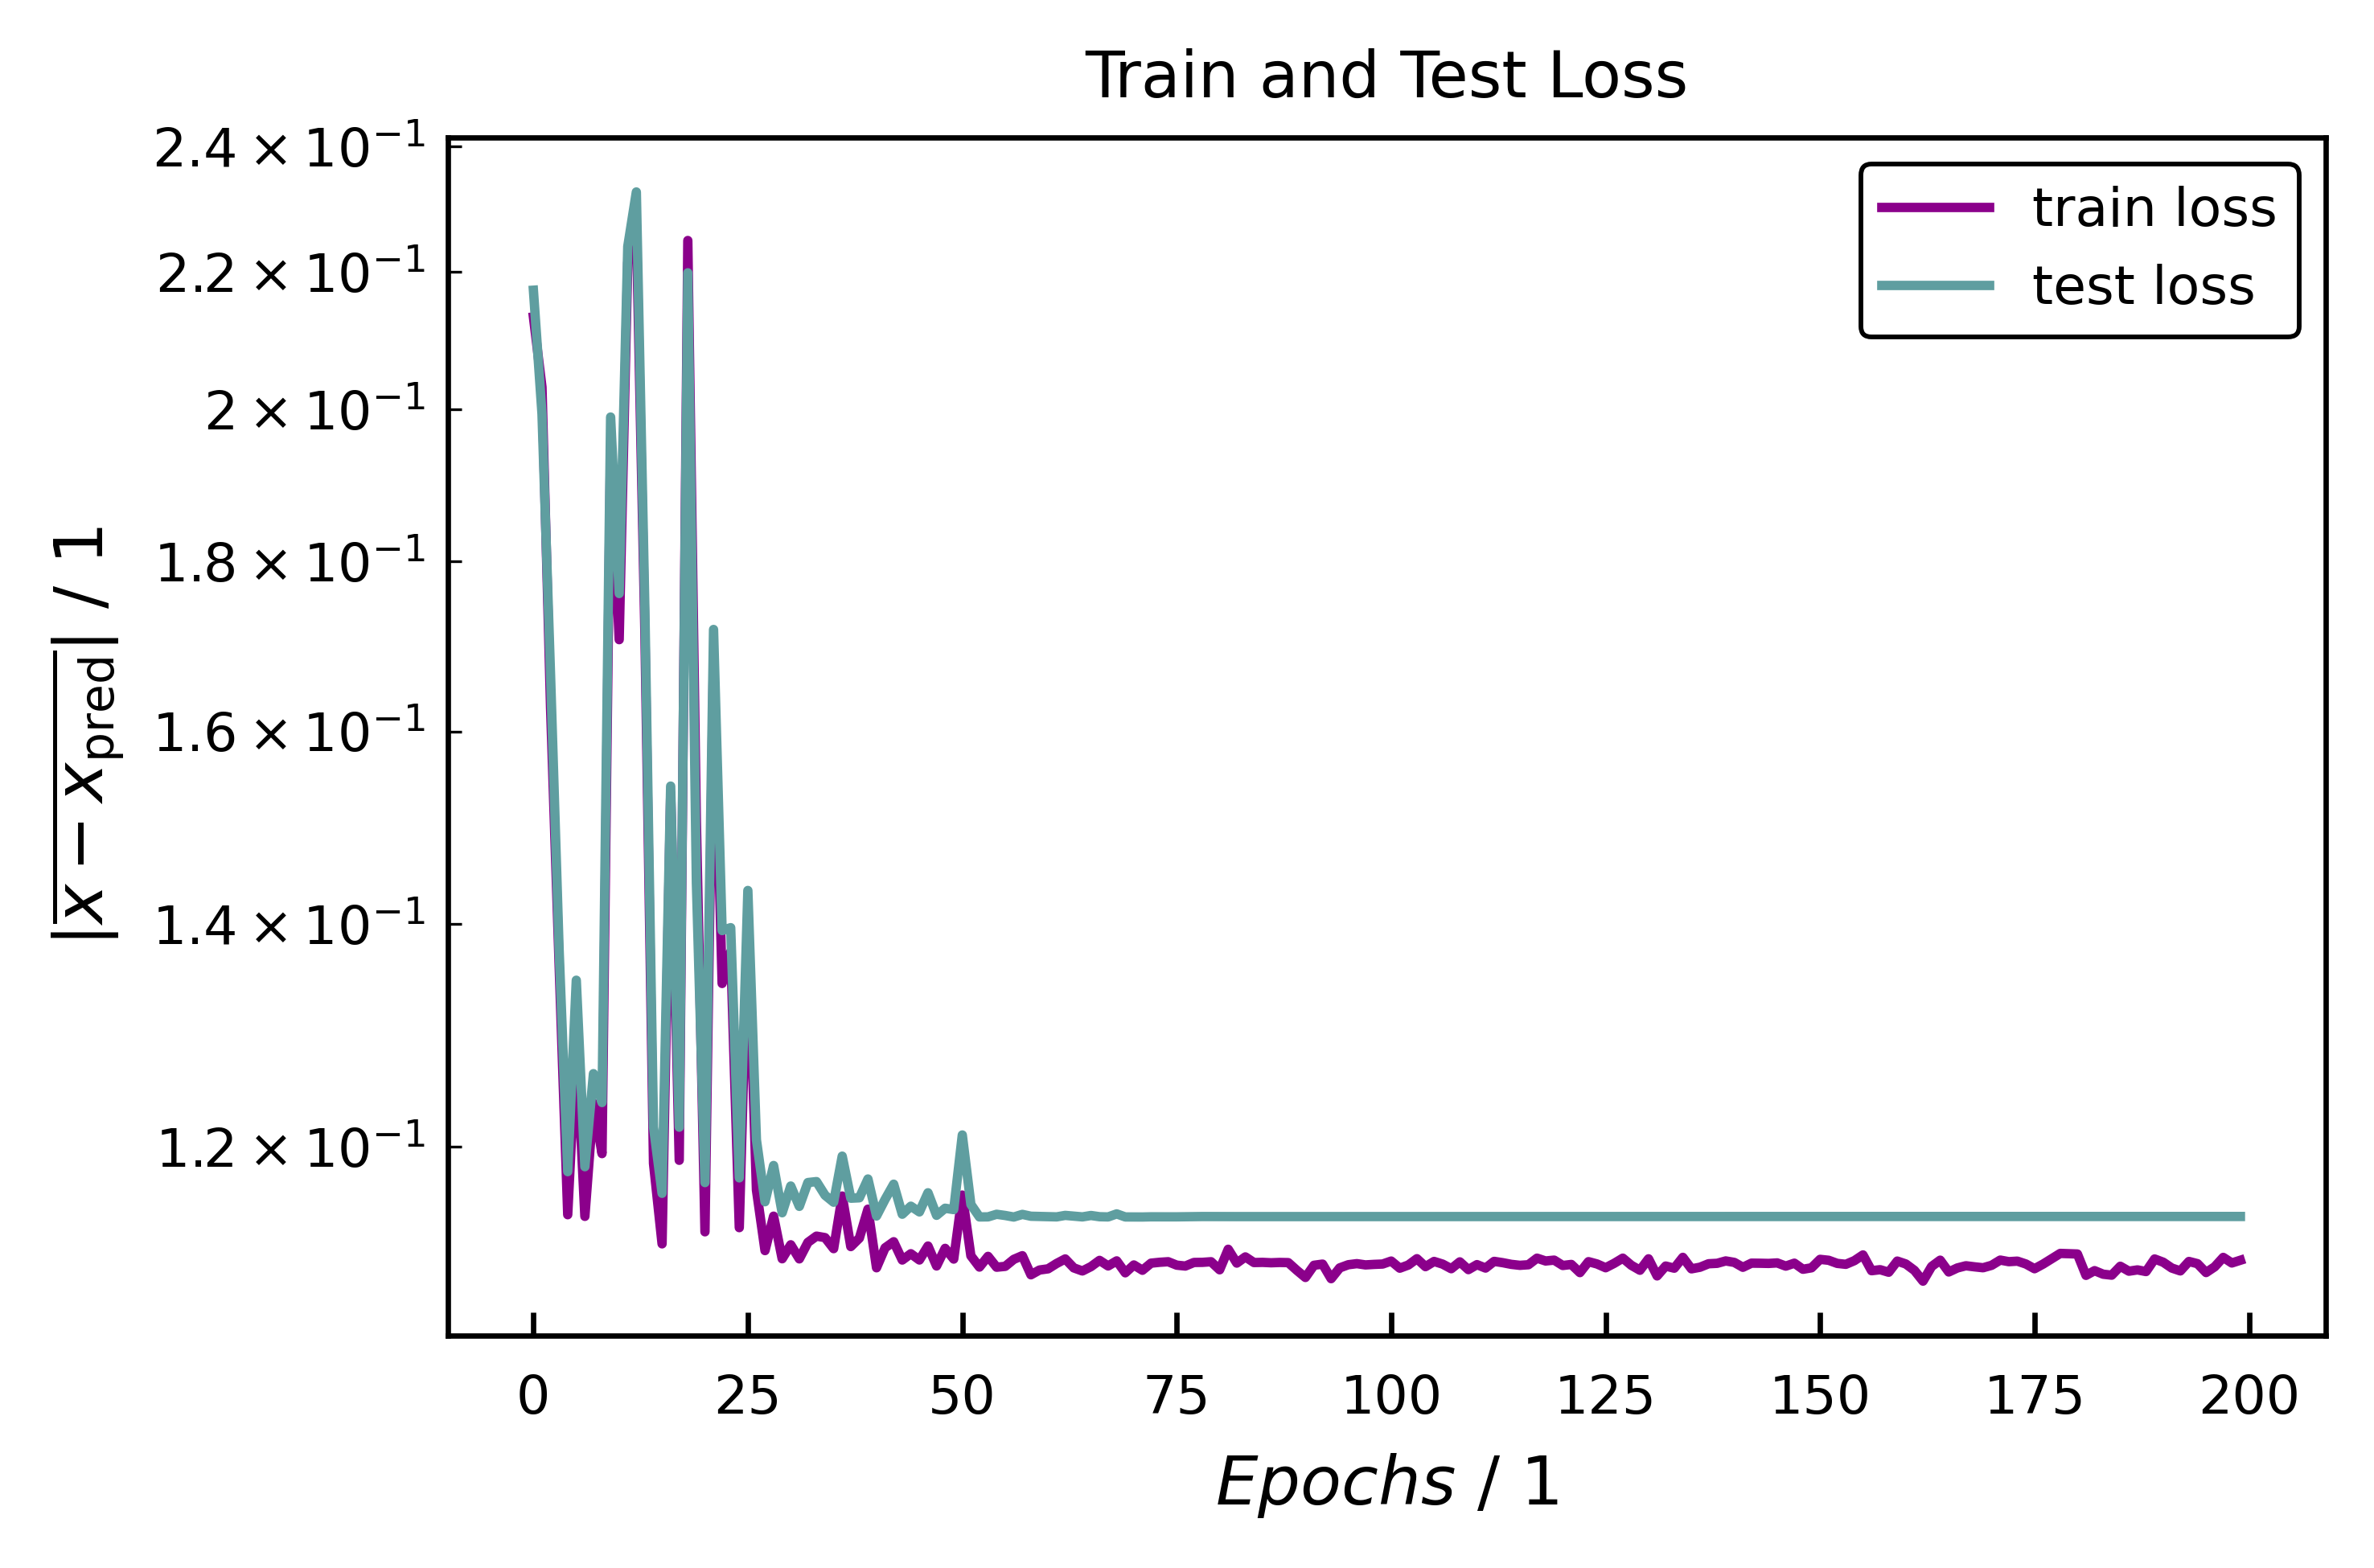

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = -0.0022748963152963153 , R^2(NH3) = -0.03176628130285564
Test Dataset: R^2(H2) = -0.0004170024505572023 , R^2(NH3) = -0.013475365366797387
Test Dataset: R^2(gemittelt)= -0.006946183908677295
Max Error Training: |x_H2 - x_H2,pred| = 0.47073886997510683 , |x_NH3 - x_NH3,pred| = 0.28046165636744363
Max Error Test: |x_H2 - x_H2,pred| = 0.448030689177073 , |x_NH3 - x_NH3,pred| = 0.29501805643090573


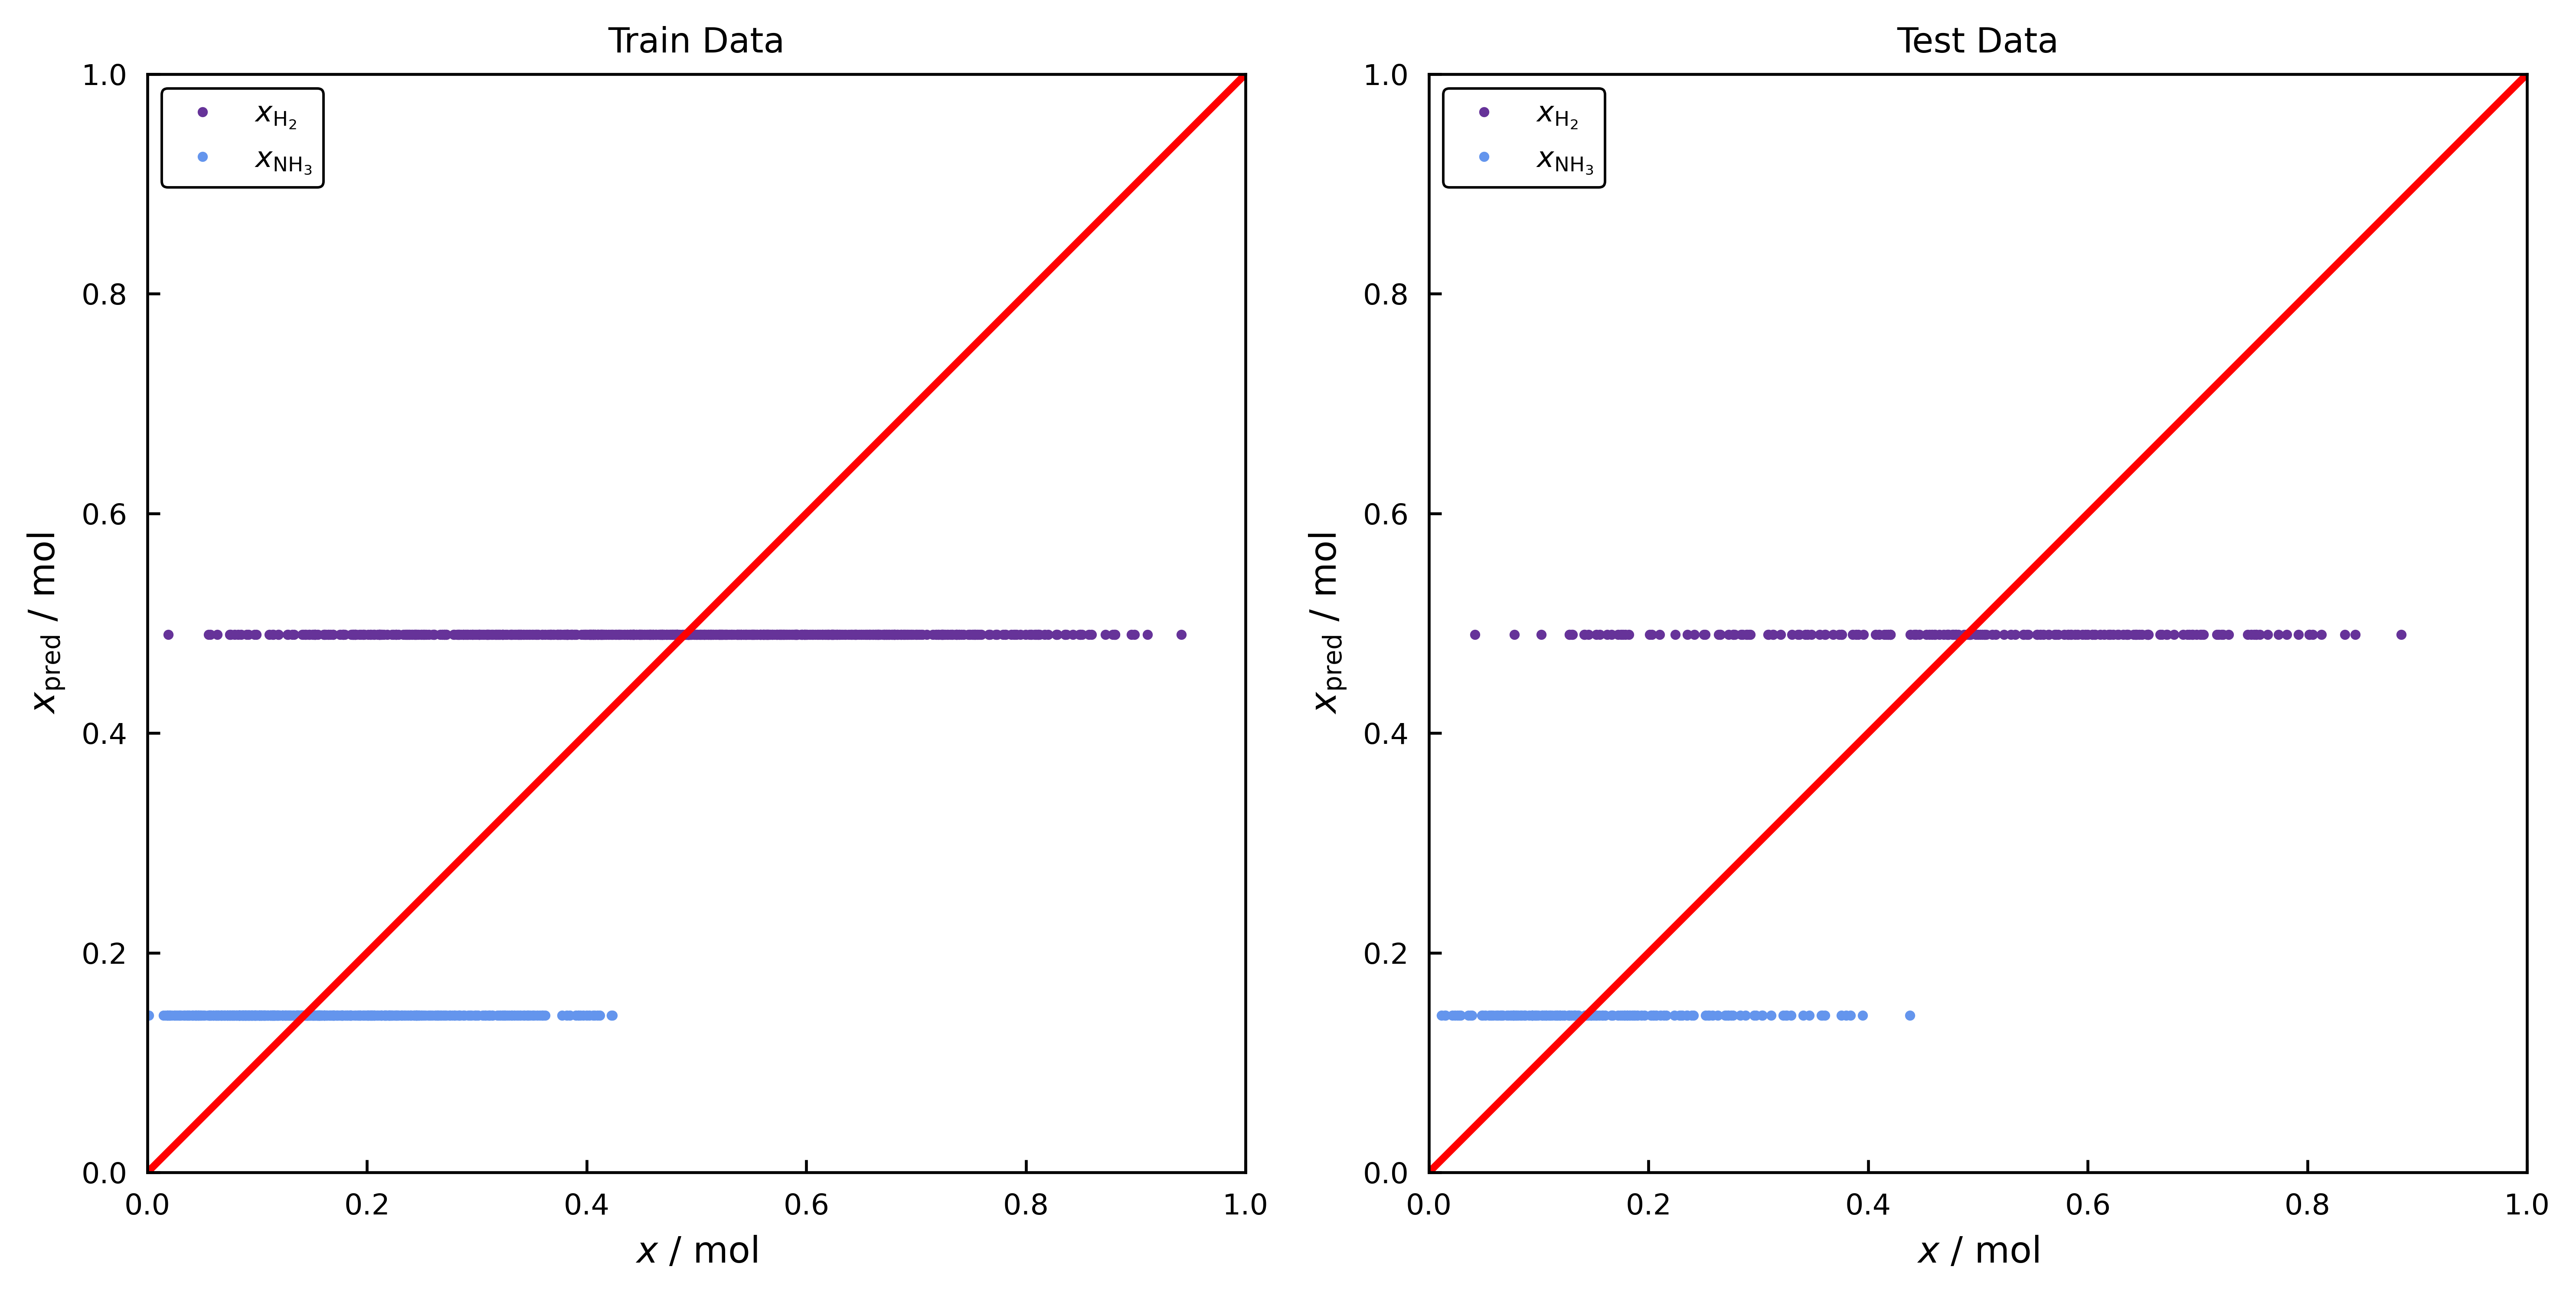

In [12]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Test Dataset: R^2(gemittelt)=', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

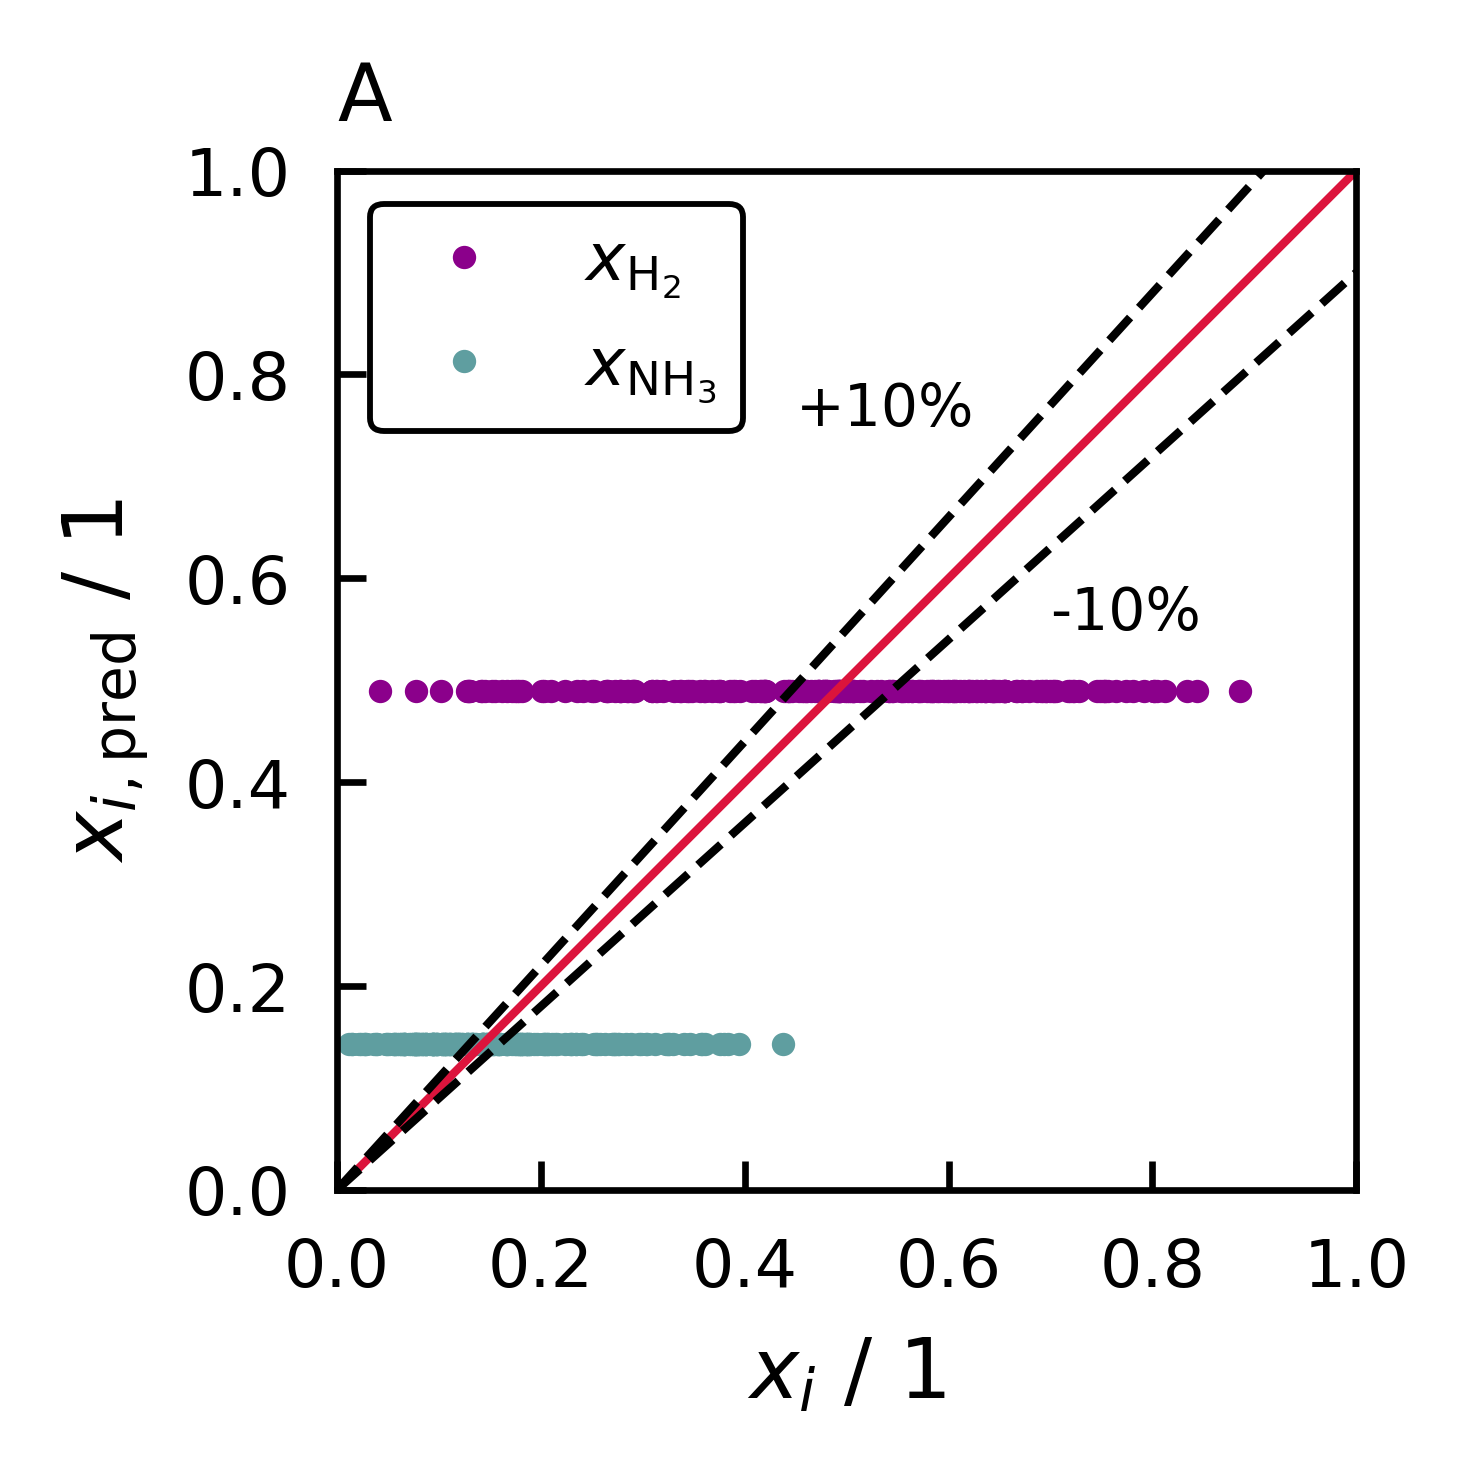

In [13]:
fig,ax = plt.subplots(figsize =(6.5*cm,6.5*cm))

# Reset the limits
#ax= plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-",color='crimson',lw=1 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax.text(0.45, 0.75, '+10%', fontsize=7)
ax.text(0.7, 0.55, '-10%', fontsize=7)


ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('A',loc='left')
ax.legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [14]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_012_parity_nonorm.png', bbox_inches = 'tight')

#### Plot Fehler vs Epoch

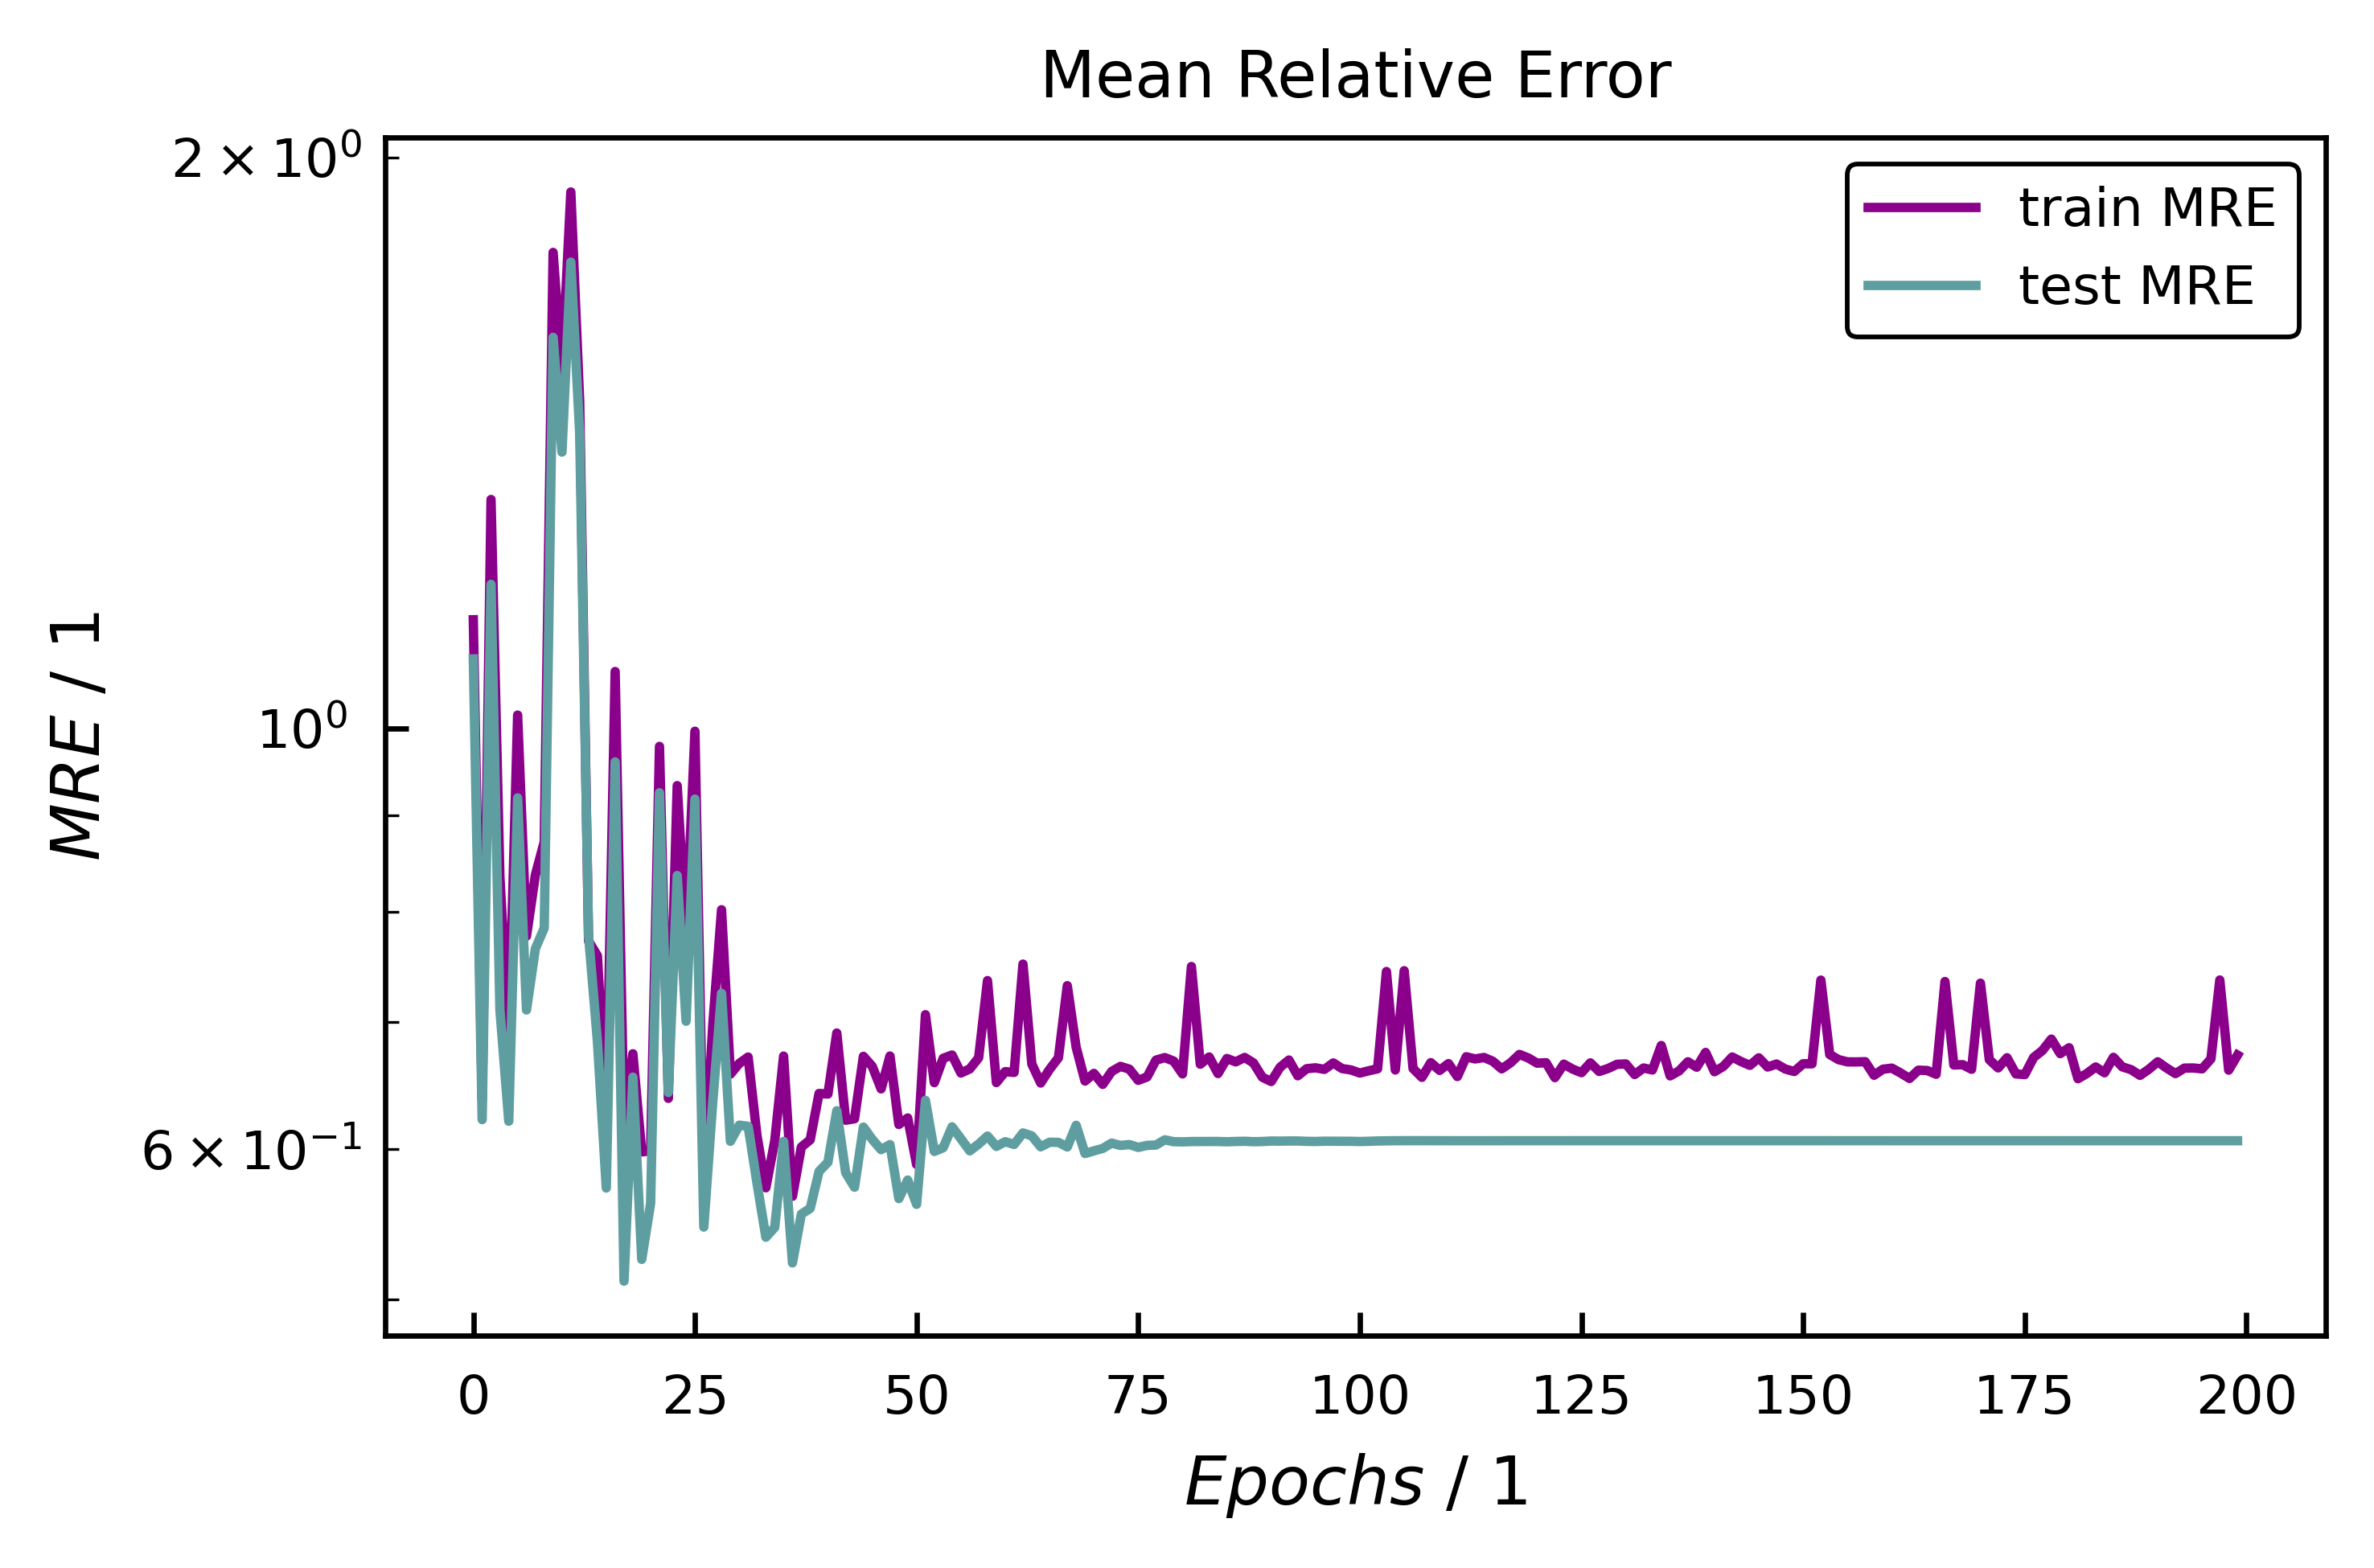

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

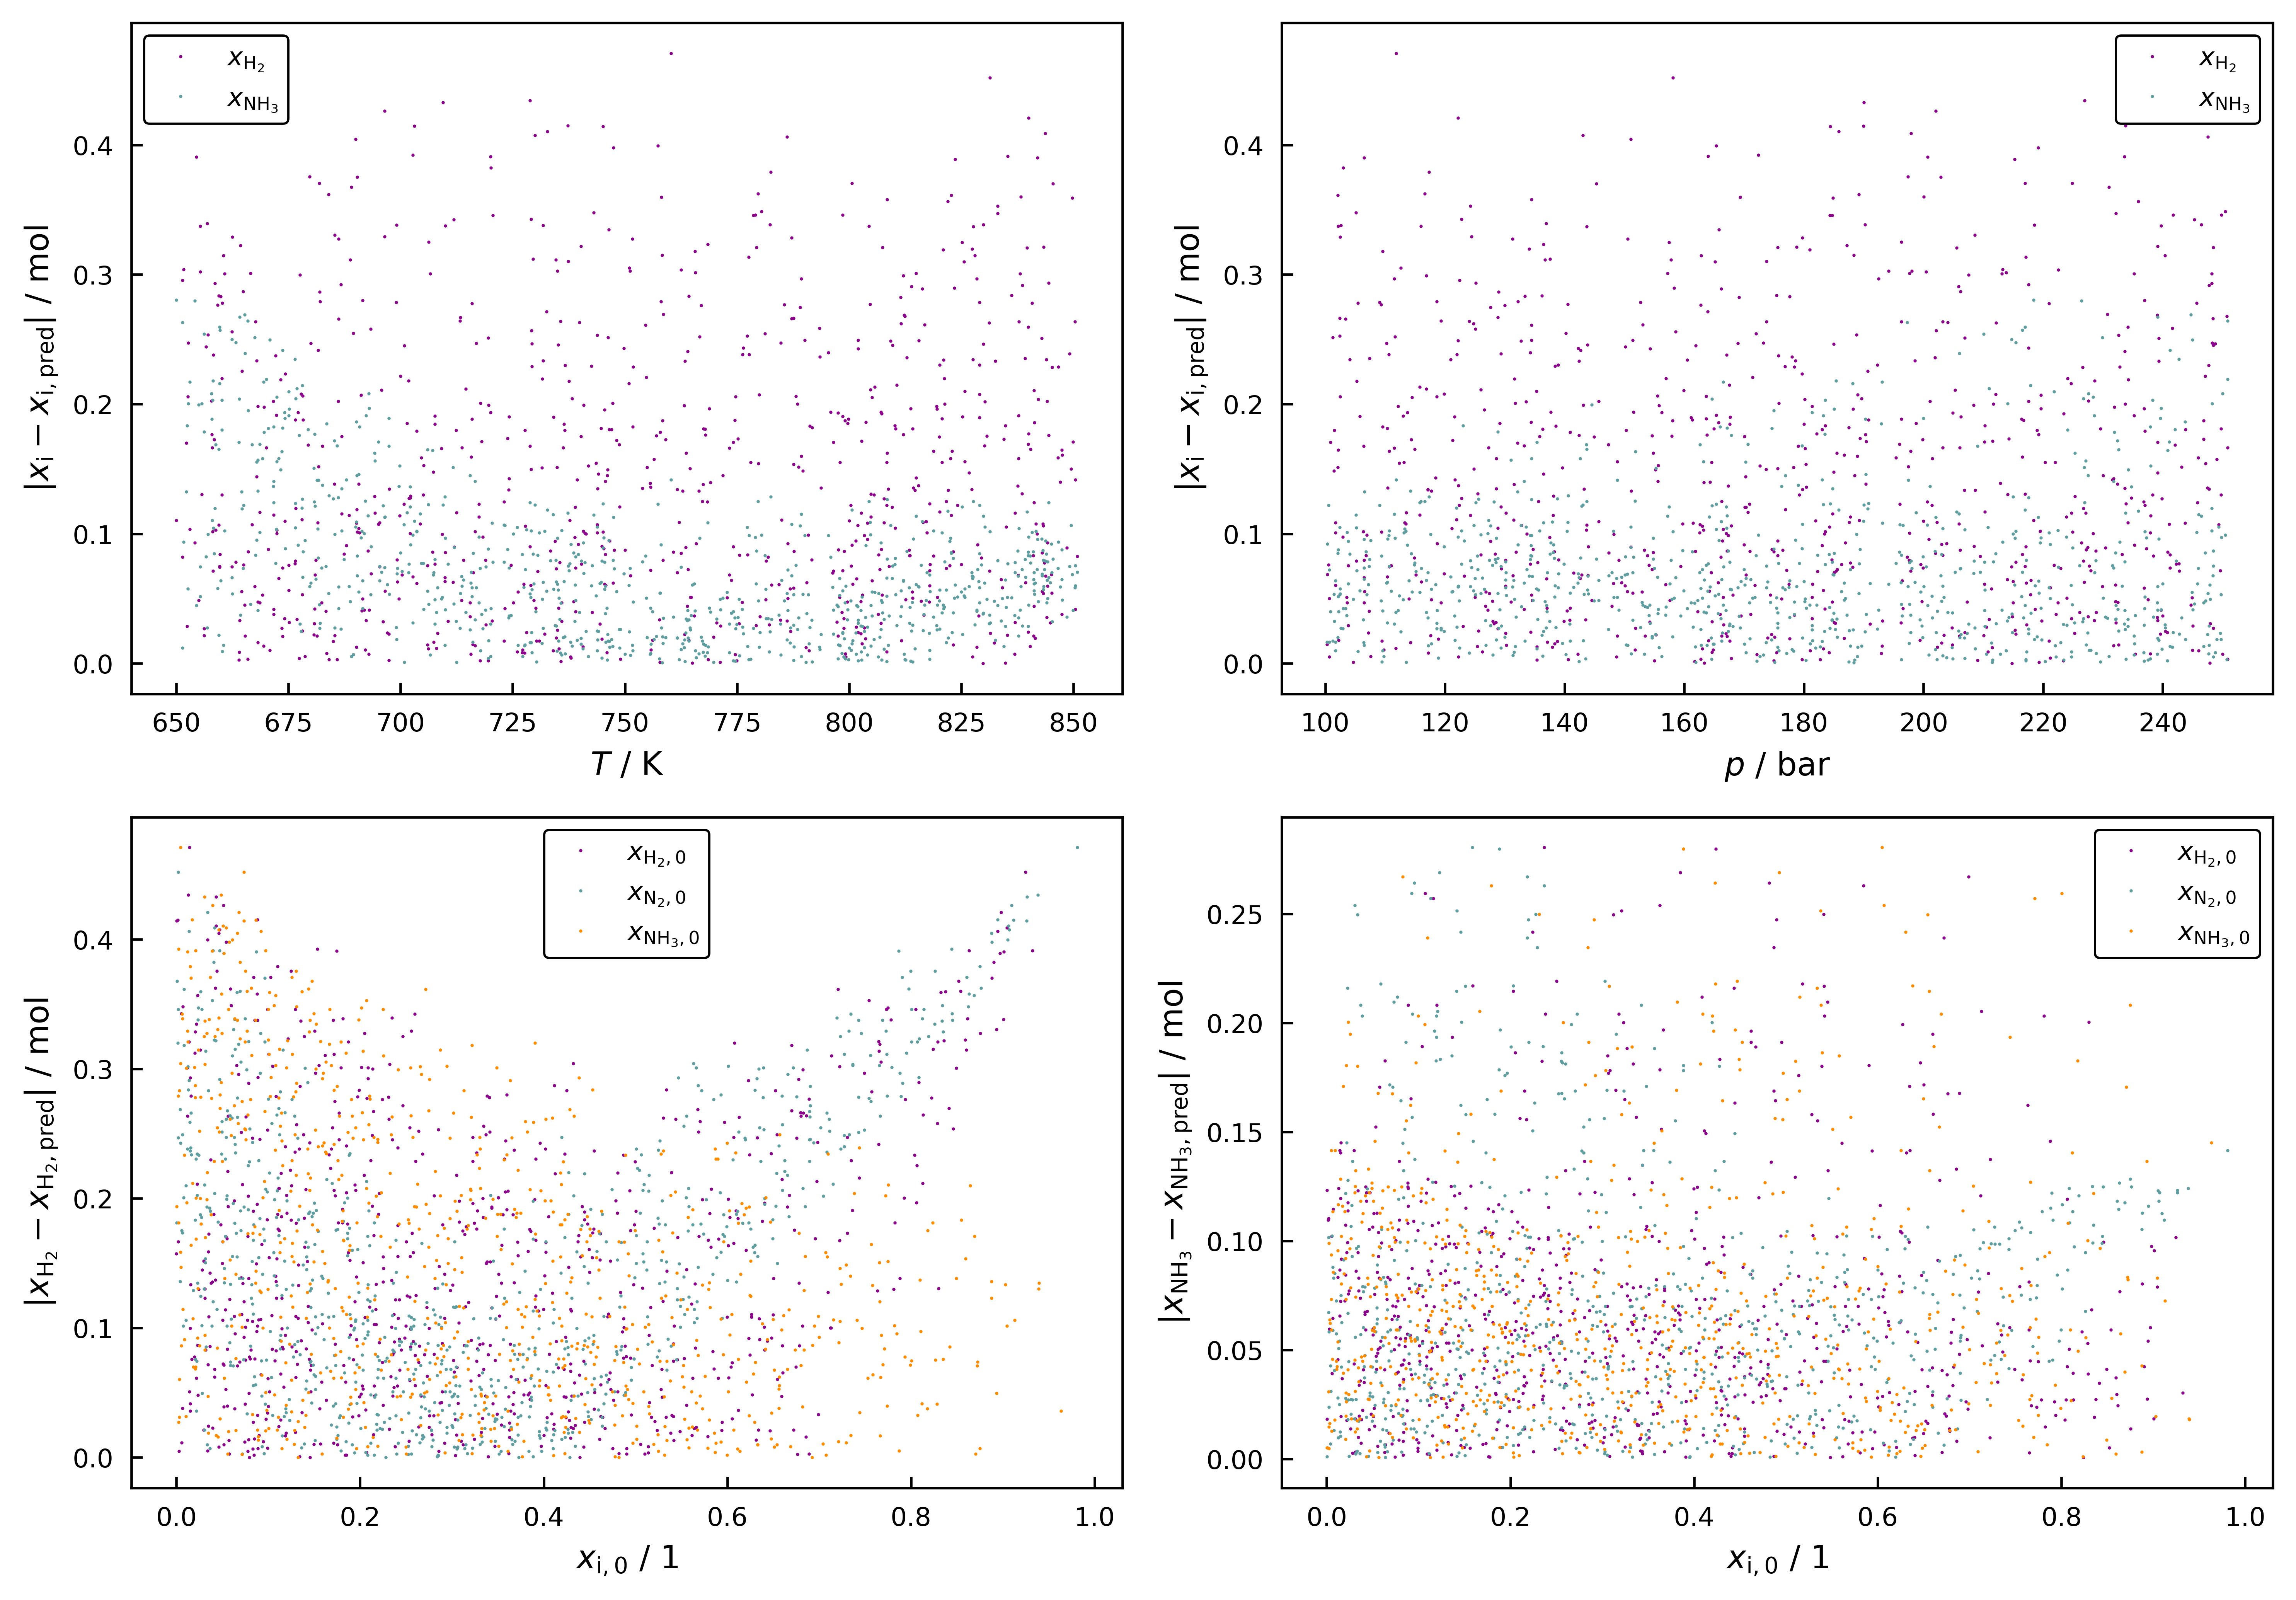

In [16]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

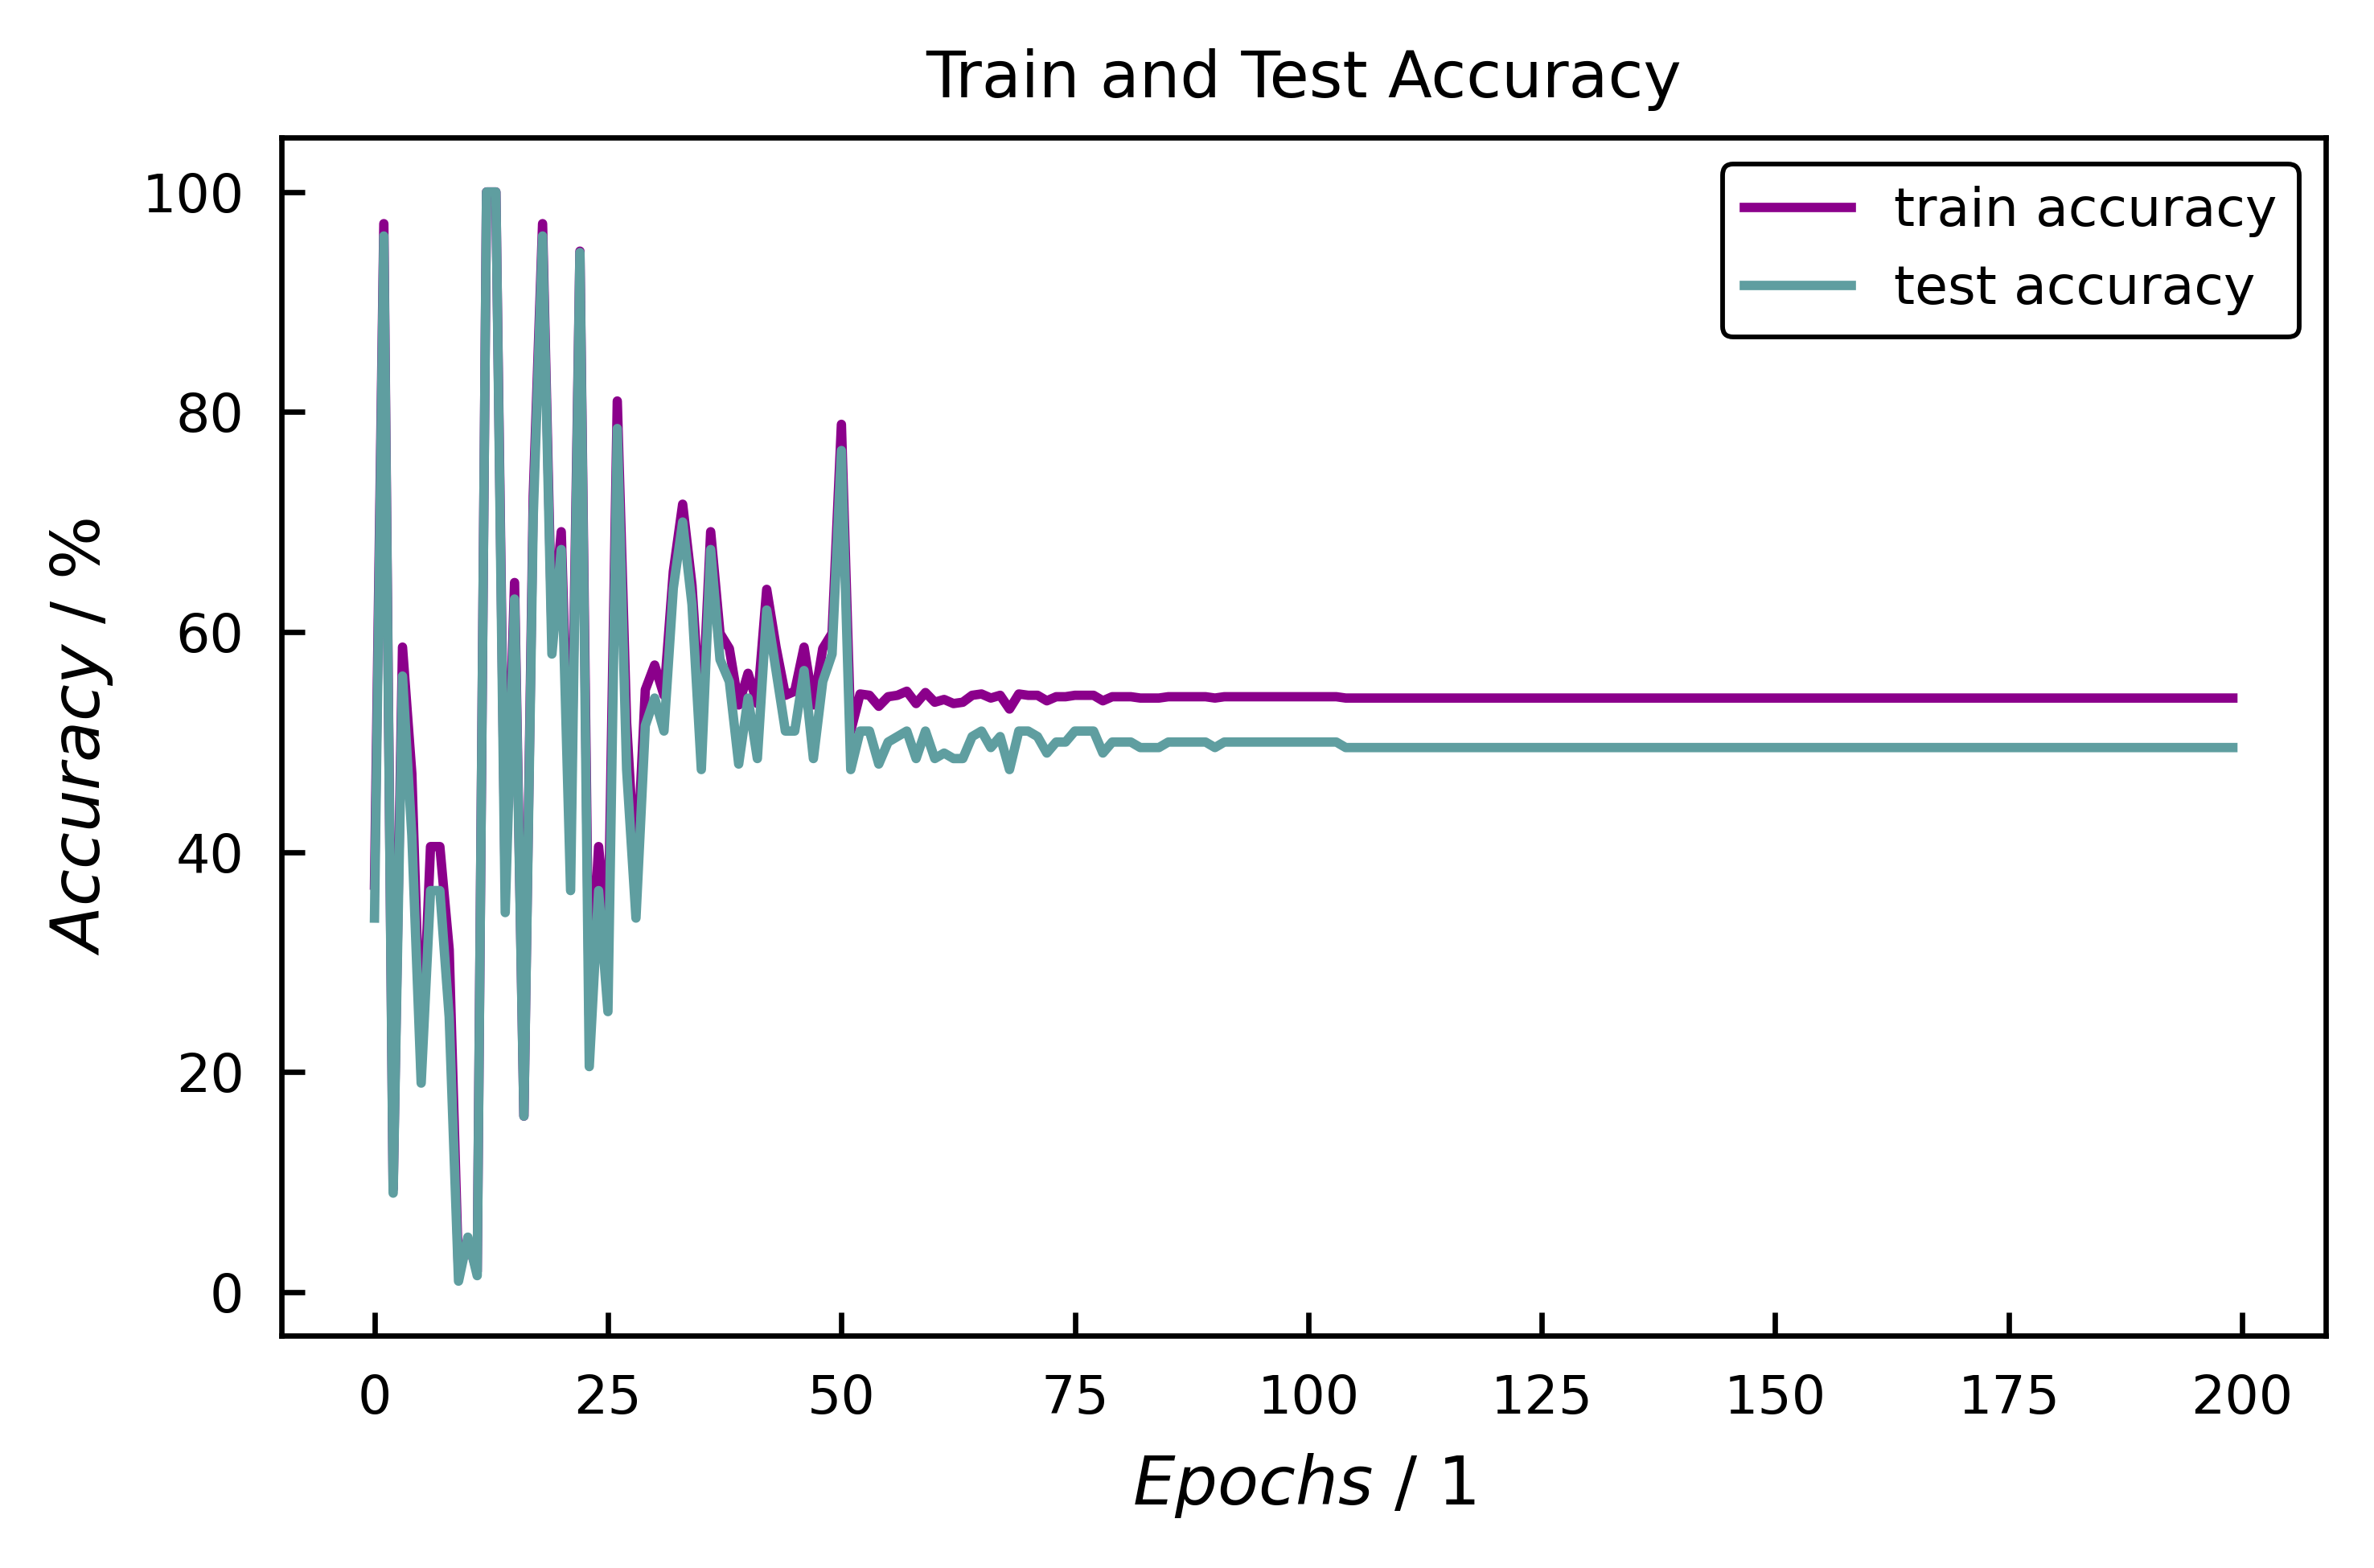

In [17]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [18]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[8.4294e+02, 2.3933e+02, 7.0641e-02, 7.4278e-01, 1.8658e-01],
        [7.8763e+02, 2.3689e+02, 1.8416e-01, 1.9503e-01, 6.2080e-01],
        [8.1355e+02, 1.5385e+02, 8.1097e-02, 2.3549e-01, 6.8342e-01],
        [8.1683e+02, 1.5304e+02, 5.4359e-01, 5.4085e-02, 4.0233e-01],
        [8.4192e+02, 1.3367e+02, 1.4999e-02, 2.3847e-01, 7.4653e-01],
        [7.1578e+02, 2.1650e+02, 3.8301e-01, 4.5801e-01, 1.5898e-01],
        [6.9021e+02, 1.7694e+02, 5.6106e-01, 8.2732e-02, 3.5621e-01],
        [7.8773e+02, 1.6185e+02, 6.7828e-01, 3.1649e-01, 5.2342e-03],
        [7.5851e+02, 1.9762e+02, 3.3934e-01, 4.2673e-01, 2.3394e-01],
        [7.0764e+02, 1.1300e+02, 7.3587e-01, 1.5236e-01, 1.1177e-01],
        [8.4652e+02, 2.4593e+02, 4.0232e-01, 5.9299e-01, 4.6883e-03],
        [7.9162e+02, 1.8469e+02, 3.7350e-01, 4.7972e-01, 1.4677e-01],
        [7.9839e+02, 2.2888e+02, 1.0012e-01, 3.8555e-01, 5.1433e-01],
        [6.8530e+02, 1.1762e+02, 6.3391e-01, 2.7784e-01, 8.8248e-02],
        [6.6948e+02,

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 3.6234e-01,  3.5219e-01, -4.9310e-02, -2.0806e-01,  2.9014e-01],
         [-1.6746e-01, -2.2762e-01, -5.4426e-02,  3.1647e-01,  9.0676e-04],
         [ 3.7888e-01, -9.4125e-03,  4.0042e-01, -2.7191e-01,  4.6269e-02],
         [-6.0088e-03, -2.8442e-01, -3.7256e-01, -3.0008e-01, -2.1712e-01],
         [ 3.9413e-01, -7.9830e-02,  3.3706e-02,  3.7943e-01, -4.0747e-02],
         [ 2.3827e-01,  1.2359e-02, -2.0081e-01, -1.7246e-01, -3.7235e-01],
         [ 4.3811e-01,  4.3828e-01,  3.6346e-01, -3.6392e-01,  1.5020e-01],
         [ 3.1793e-01, -1.7925e-01,  3.6471e-01,  3.0121e-01, -7.2212e-03],
         [-6.7817e-02, -3.0703e-01,  7.5466e-02,  9.4932e-02, -2.4019e-01],
         [ 1.9738e-01,  2.9434e-01, -4.3221e-01, -1.0000e-01, -8.9483e-02],
         [ 3.4125e-02, -4.4997e-01,  9.4029e-02, -3.2544e-01,  1.7569e-01],
         [ 2.4645e-01, -1.9141e-01, -9.9671e-02, -4.4720e-01, -1.9459e-01],
         [ 3.2789e-01,  3.0209e-01,  2.5808e-01, -2.6641e-01,  3.

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.2165, 0.1830, 0.1810, 0.7721, 0.8779],
        [0.1045, 0.6370, 0.9711, 0.3987, 0.3853]])
tensor([[0.4951, 0.1472],
        [0.4961, 0.1451]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[6.7653e+02, 1.9081e+02, 2.2000e-01, 4.2706e-01, 3.5294e-01],
        [8.0203e+02, 2.4077e+02, 1.1158e-01, 3.5659e-01, 5.3183e-01],
        [6.9137e+02, 1.4040e+02, 5.5538e-01, 3.2527e-01, 1.1934e-01],
        [7.1665e+02, 1.0637e+02, 6.8160e-01, 2.5850e-01, 5.9902e-02],
        [7.1170e+02, 2.2685e+02, 3.6448e-01, 8.4737e-02, 5.5078e-01],
        [8.0834e+02, 2.0143e+02, 2.3858e-01, 5.4555e-01, 2.1587e-01],
        [7.3054e+02, 1.8226e+02, 6.6392e-02, 6.1826e-02, 8.7178e-01],
        [6.9908e+02, 1.5268e+02, 1.9727e-01, 6.7532e-01, 1.2741e-01],
        [6.7648e+02, 2.4271e+02, 4.8674e-01, 2.2911e-01, 2.8416e-01],
        [6.7515e+02, 1.8507e+02, 4.6189e-01, 1.1719e-01, 4.2092e-01],
        [7.2761e+02, 1.1720e+02, 4.6268e-02, 3.0266e-01, 6.5107e-01],
        [8.2349e+02, 1.5828e+02, 8.0834e-01, 1.4293e-01, 4.8721e-02],
        [8.3141e+02, 1.5810e+02, 9.2447e-01, 1.9311e-03, 7.3598e-02],
        [7.1808e+02, 1.9041e+02, 2.1501e-01, 5.0076e-01, 2.8423e-01],
        [7.2925e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()